In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import all of them
sales = pd.read_csv(
    "/Users/liruizhi/downloads/实习/浪潮Inspur/Time Series/competitive-data-science-predict-future-sales/sales_train.csv")
item_cat = pd.read_csv(
    "/Users/liruizhi/downloads/实习/浪潮Inspur/Time Series/competitive-data-science-predict-future-sales/item_categories.csv")
item = pd.read_csv(
    "/Users/liruizhi/downloads/实习/浪潮Inspur/Time Series/competitive-data-science-predict-future-sales/items.csv")
sub = pd.read_csv(
    "/Users/liruizhi/downloads/实习/浪潮Inspur/Time Series/competitive-data-science-predict-future-sales/sample_submission.csv")
shops = pd.read_csv(
    "/Users/liruizhi/downloads/实习/浪潮Inspur/Time Series/competitive-data-science-predict-future-sales/shops.csv")
test = pd.read_csv(
    "/Users/liruizhi/downloads/实习/浪潮Inspur/Time Series/competitive-data-science-predict-future-sales/test.csv")

In [3]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [7]:
sales.date = sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [8]:
sales.date

0         2013-01-02
1         2013-01-03
2         2013-01-05
3         2013-01-06
4         2013-01-15
             ...    
2935844   2015-10-10
2935845   2015-10-09
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-10-03
Name: date, Length: 2935849, dtype: datetime64[ns]

# Description of Data

In [9]:
# Aggregate to monthly level the required metrics

monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id'])['date', 'item_price', 'item_cnt_day'].agg(
    {'date': ['min', 'max'], 'item_price': 'mean', 'item_cnt_day': 'sum'})

# Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

In [10]:
# take a peak
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

In [11]:
# number of items per cat
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id', ascending=False)
x = x.iloc[0:10].reset_index()

In [12]:
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


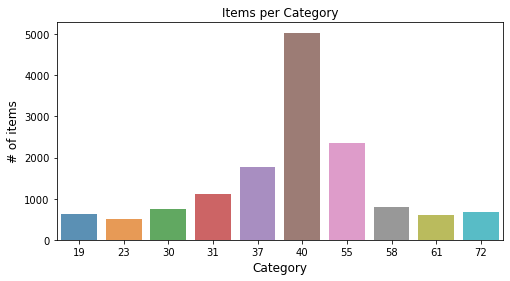

In [13]:
#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

# Time Series Part
## Single series
### The objective requires us to predict sales for the next month at a store-item combination.

### Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

### I've chosen to predict for the total sales per month for the entire company.

### First let's compute the total sales per month and plot that data.

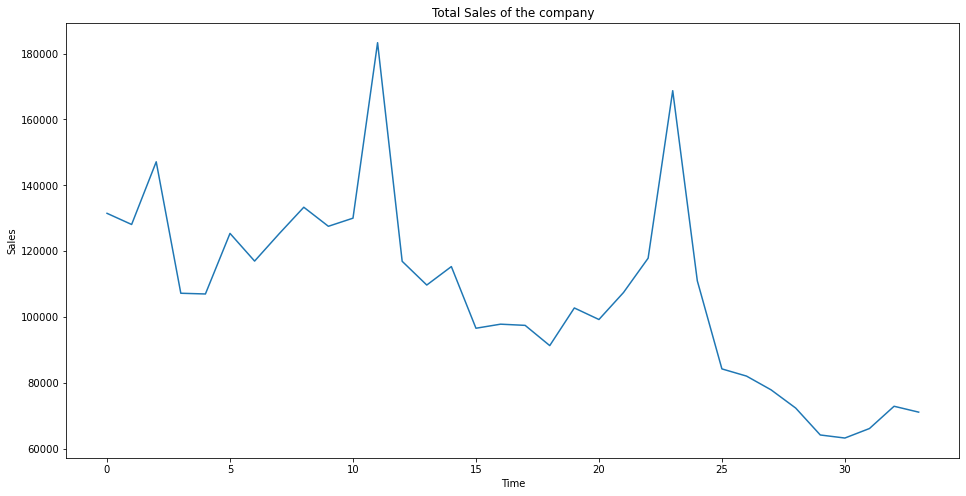

In [4]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.astype('float')
plt.figure(figsize=(16, 8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

In [5]:
type(ts)

pandas.core.series.Series

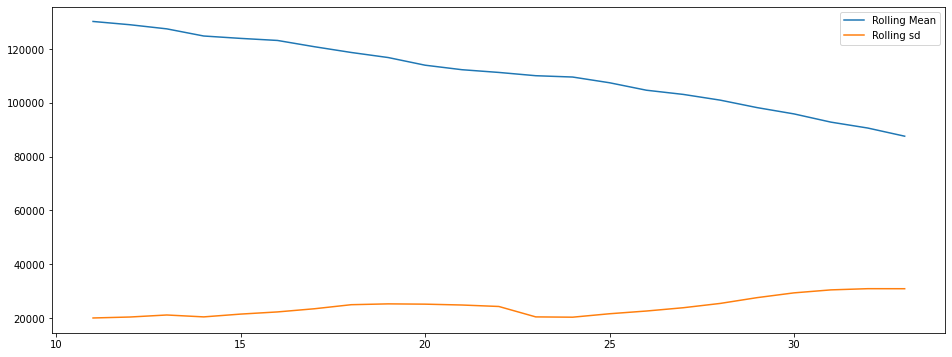

In [16]:
# 移动平均
plt.figure(figsize=(16, 6))
plt.plot(ts.rolling(window=12, center=False).mean(), label='Rolling Mean')
plt.plot(ts.rolling(window=12, center=False).std(), label='Rolling sd')
plt.legend()

### Quick observations: There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

#### Let's check that with a quick decomposition into Trend, seasonality and residuals.

In [17]:
ts.values

array([131479., 128090., 147142., 107190., 106970., 125381., 116966.,
       125291., 133332., 127541., 130009., 183342., 116899., 109687.,
       115297.,  96556.,  97790.,  97429.,  91280., 102721.,  99208.,
       107422., 117845., 168755., 110971.,  84198.,  82014.,  77827.,
        72295.,  64114.,  63187.,  66079.,  72843.,  71056.])

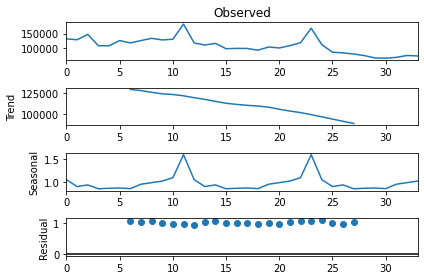

In [18]:
import statsmodels.api as sm
# multiplicative 乘法模型
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model='multiplicative')
#plt.figure(figsize=(16, 12))
fig = res.plot()
#fig.show()

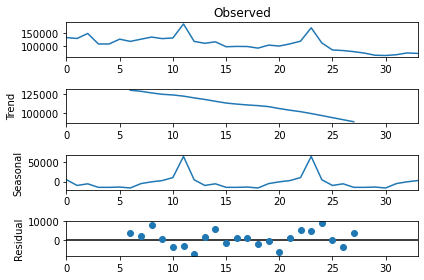

In [19]:
# Additive model 加法模型
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model='additive')
#plt.figure(figsize=(16, 12))
fig = res.plot()
#fig.show()

#### We assume an additive model, then we can write
#### yt=St+Tt+Et
#### Where yt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period tt and Et is the remainder (or irregular or error) component at period t Similarly for Multiplicative model,
#### yt=St x Tt x Et


# Stationarity 平稳性
## 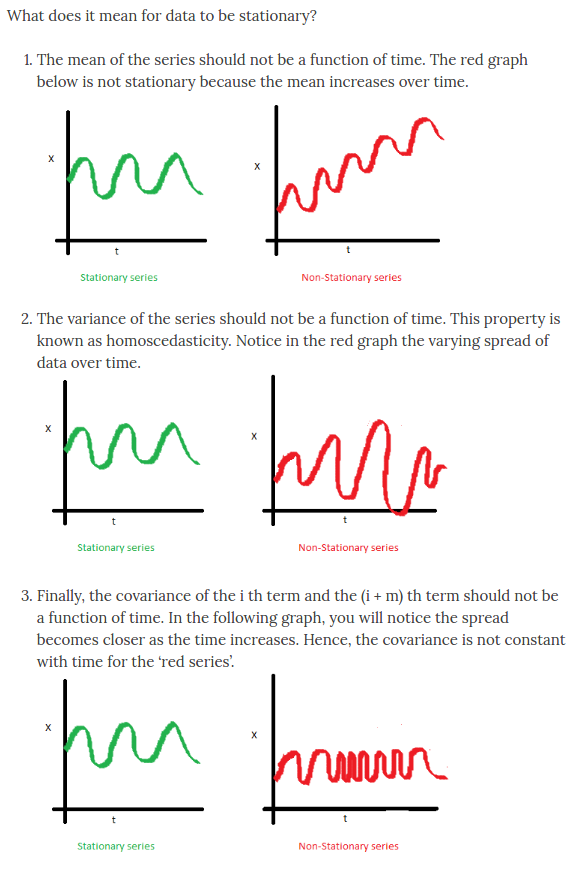
#### Stationarity refers to time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)
#### When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.
#### There are multiple tests that can be used to check stationarity.
#### · ADF (Augmented Dicky Fuller Test)
#### · KPSS
#### · PP (Phillips-Perron test)
#### Let's just perform the ADF which is the most commonly used one.

In [20]:
# Stationarity tests 稳定性检验
def test_stationarity(timeseries):
    
    # Perform Dickey-Fuller Test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC') # 选择滞后数以最小化相应的信息标准
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Obervations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                -2.395704
p-value                        0.142953
#Lags Used                     0.000000
Number of Obervations Used    33.000000
Critical Value (1%)           -3.646135
Critical Value (5%)           -2.954127
Critical Value (10%)          -2.615968
dtype: float64


In [21]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [22]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
print(type(ts))
print(type(ts[0]))
print(ts)
print(difference(ts))

<class 'pandas.core.series.Series'>
<class 'numpy.float64'>
date_block_num
0     131479.0
1     128090.0
2     147142.0
3     107190.0
4     106970.0
5     125381.0
6     116966.0
7     125291.0
8     133332.0
9     127541.0
10    130009.0
11    183342.0
12    116899.0
13    109687.0
14    115297.0
15     96556.0
16     97790.0
17     97429.0
18     91280.0
19    102721.0
20     99208.0
21    107422.0
22    117845.0
23    168755.0
24    110971.0
25     84198.0
26     82014.0
27     77827.0
28     72295.0
29     64114.0
30     63187.0
31     66079.0
32     72843.0
33     71056.0
Name: item_cnt_day, dtype: float64
0     -3389.0
1     19052.0
2    -39952.0
3      -220.0
4     18411.0
5     -8415.0
6      8325.0
7      8041.0
8     -5791.0
9      2468.0
10    53333.0
11   -66443.0
12    -7212.0
13     5610.0
14   -18741.0
15     1234.0
16     -361.0
17    -6149.0
18    11441.0
19    -3513.0
20     8214.0
21    10423.0
22    50910.0
23   -57784.0
24   -26773.0
25    -2184.0
26    -4187.0
27

[]

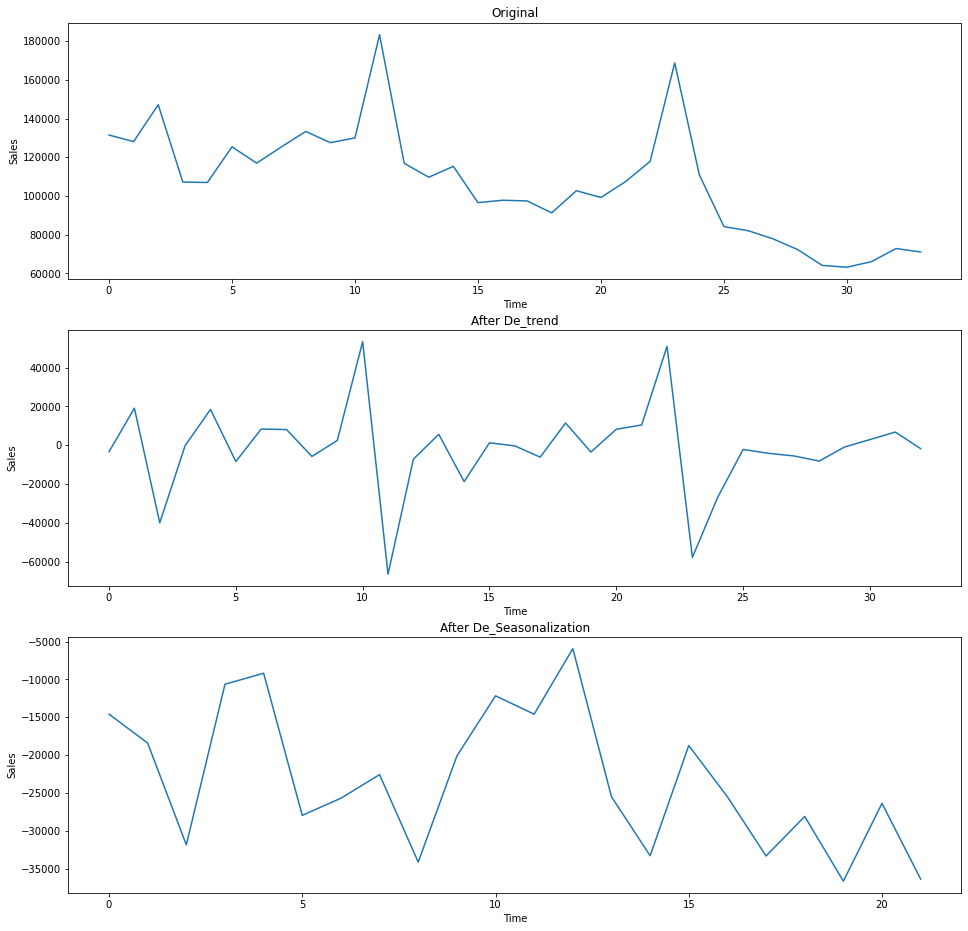

In [23]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.astype('float')

plt.figure(figsize=(16, 16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
plt.title('After De_trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts)   # 后 - 前 去趋势？
plt.plot(new_ts)
plt.plot()
            
plt.subplot(313)
plt.title('After De_Seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts, 12)  # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [24]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                -3.270101
p-value                        0.016269
#Lags Used                     0.000000
Number of Obervations Used    21.000000
Critical Value (1%)           -3.788386
Critical Value (5%)           -3.013098
Critical Value (10%)          -2.646397
dtype: float64


### Now after the transformations, our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series
#### We can easily get back the original series using the inverse transform function that we have defined above.
#### Now let's dive into making the forecasts!

# AR, MA and ARMA models:
#### TL: DR version of the models:

#### MA - Next value in the series is a function of the average of the previous n number of values AR - The errors(difference in mean) of the next value is a function of the errors in the previous n number of values ARMA - a mixture of both.
#### MA滑动平均模型 -序列中的下一个值是前n个值的平均值的函数

#### AR自回归模型  -下一个值的误差(均值之差)是前n个值的误差的函数

#### ARMA -两者的混合物。

#### Now, How do we find out, if our time-series in AR process or MA process?

#### Let's find out!

In [25]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh', title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        # 自相关图是一个平面二维坐标悬垂线图。横坐标表示延迟阶数，纵坐标表示自相关系数
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        # 偏自相关图跟自相关图类似，横坐标表示延迟阶数，纵坐标表示偏自相关系数
        sm.qqplot(y, line='s', ax=qq_ax)
        # QQplot可以用来判断样本点是否符合任意一种概率分布，
        # 其方法就是和前面所讲normal distribution的例子一样，
        # 如果怀疑样本点符合某种分布，那么就找出从这样一个分布中抽取相同数目随机数时期望得到的数值，
        # 将这些数值与实际的样本点的值放在QQplot中进行比较，
        # 如果点的分布接近一条直线就说明，样本点的分布和猜测的分布相同，反之则不同。
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

<class 'numpy.ndarray'>


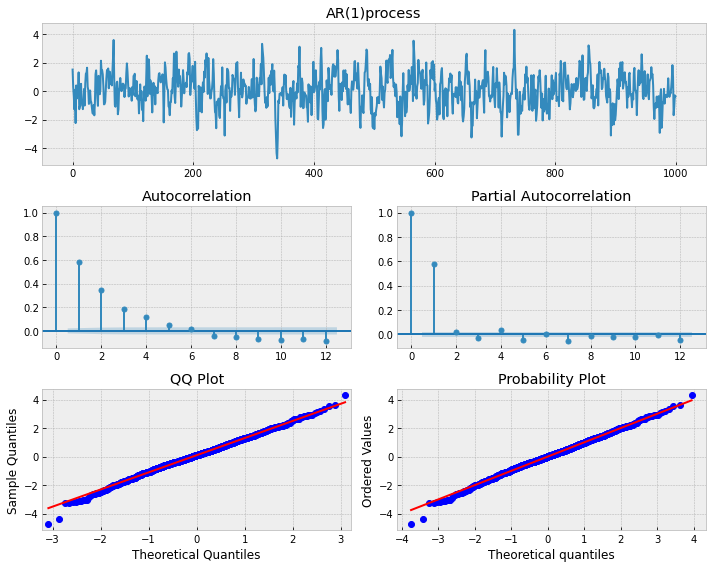

In [26]:
# Simulate an AR(1) process with alpha = 0.6
# AR(1) model will constrain phi between -1 and 1  一阶
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)   # 正态分布
print(type(x))
for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12
_ = tsplot(x, lags=limit, title='AR(1)process')


# Results: AR(1) process -- has ACF tailing out (拖尾) and PACF cutting off (截尾)at lag=1

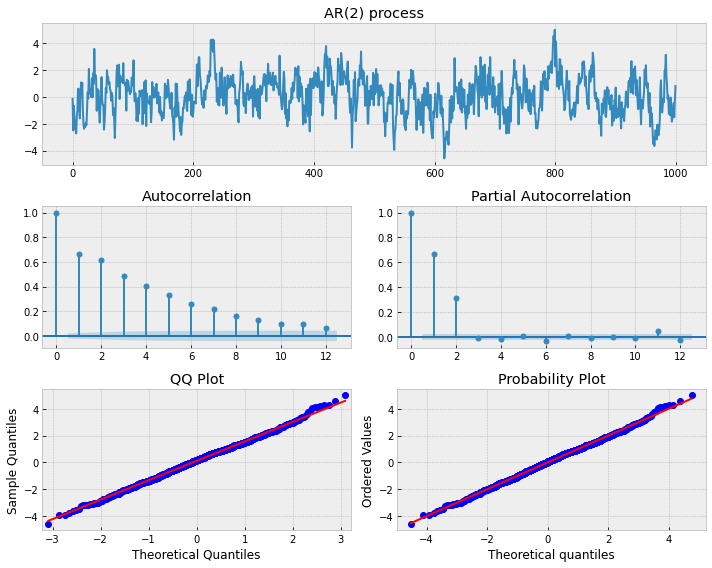

In [27]:
# Simulate an AR(2) process     二阶
# we need to define the coefficient at lag 0, 1 and 2.
# Also, we will cancel the effect of a moving average process.
n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ar2, lags=12, title='AR(2) process') 

# Results: AR(2) process -- has ACF tailing out (拖尾) and PACF cutting off (截尾) at lag=2

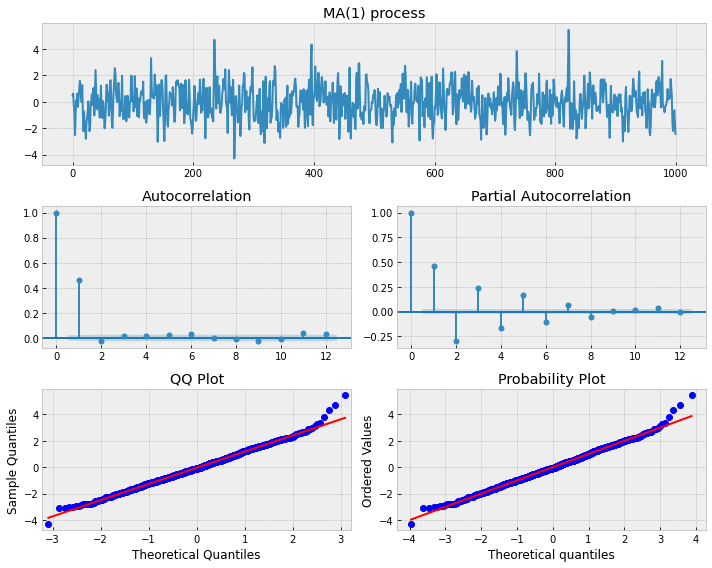

In [28]:
# Simulate an MA(1) process    一阶
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
limit = 12
_ = tsplot(ma1, lags=limit, title='MA(1) process')

# Results: MA(1) process -- has ACF cut off (截尾) at lag=1

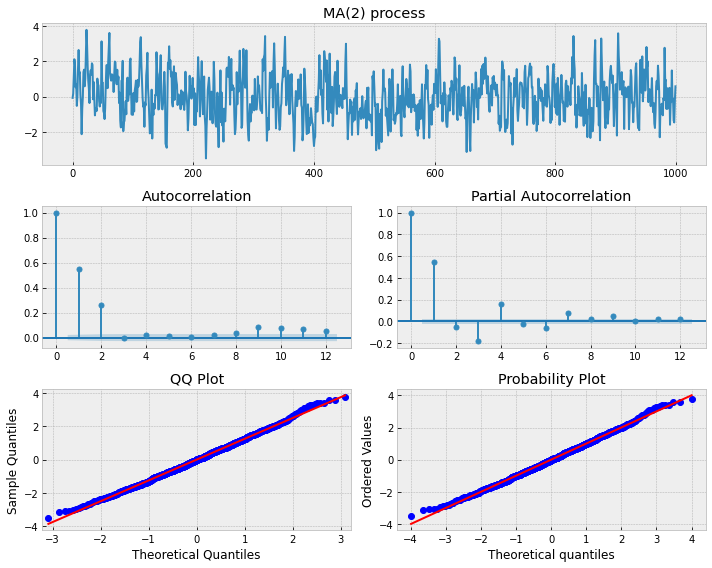

In [29]:
# Simulate MA(2) process with betas 0.6, 0.4    二阶
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
limit = 12
_ = tsplot(ma3, lags=limit, title='MA(2) process')

# MA(2) process -- has ACF cut off (截尾) at lag=2

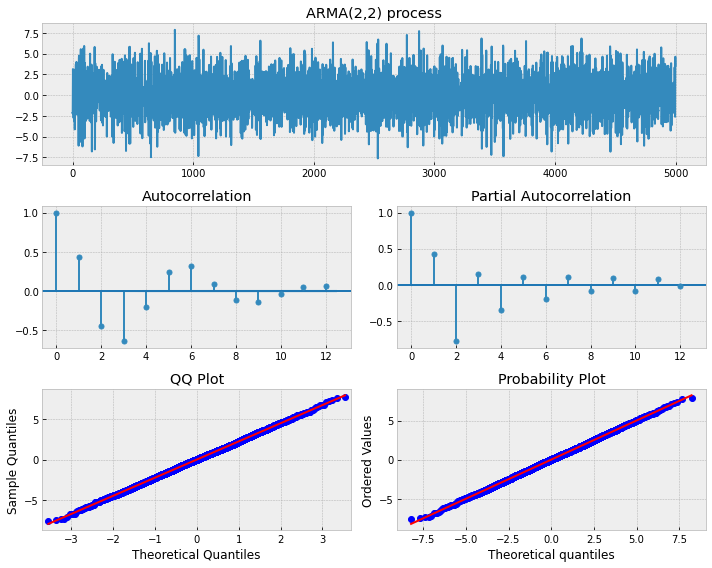

In [30]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000)  # lots of samples to help estimates
burn = int(n/10)  # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag, title="ARMA(2,2) process")

In [31]:
arma22.shape

(5000,)

# Now things get a little hazy. Its not very clear/straight-forward.
### A nifty summary of the above plots:
#### 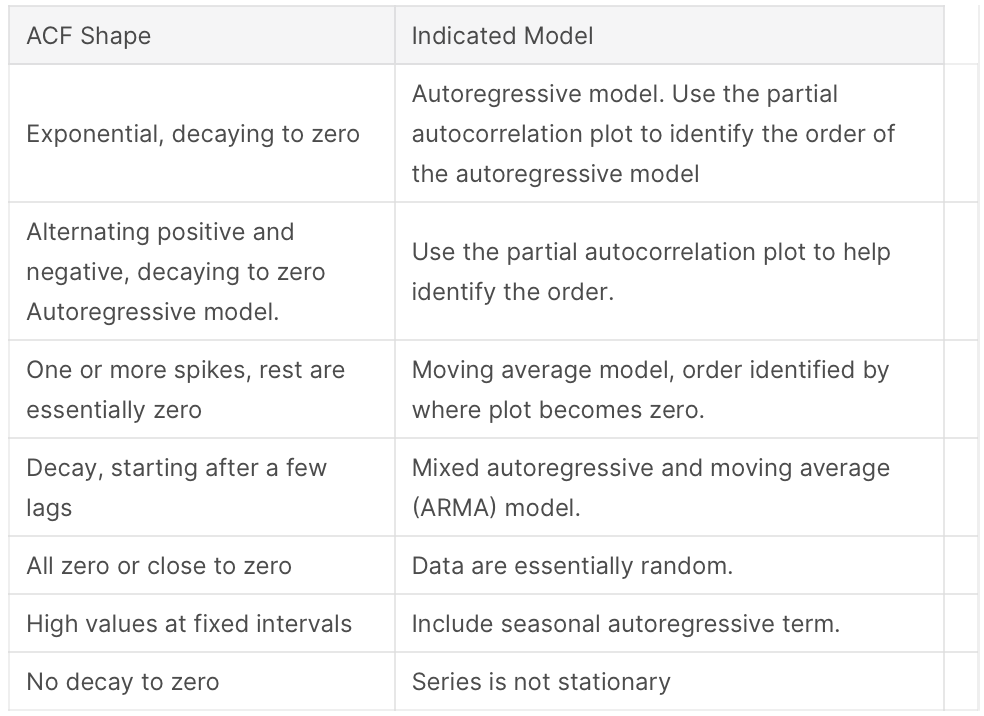
#### ACF Shape	Indicated Model
### Exponential, decaying to zero: 指数，衰减到零:	
#### Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model	自回归模型。使用偏自相关图来确定自回归模型的顺序
### Alternating positive and negative, decaying to zero Autoregressive model:	交替正负，衰减到零自回归模型:
#### Use the partial autocorrelation plot to help identify the order. 使用偏自相关图来帮助确定顺序。	
### One or more spikes, rest are essentially zero:	一个或多个峰值，其余基本上为零:
#### Moving average model, order identified by where plot becomes zero.	 移动平均模型，由图变为零的位置确定顺序。
### Decay, starting after a few lags:	衰减，开始后几个滞后:
#### Mixed autoregressive and moving average (ARMA) model.	混合自回归移动平均(ARMA)模型。
### All zero or close to zero:  全部为零或接近于零:
#### Data are essentially random.	数据基本上是随机的。
### High values at fixed intervals:	  固定间隔的高值:
#### Include seasonal autoregressive term.	  包括季节性自回归项。
### No decay to zero:	没有衰减到零:
#### Series is not stationary	序列不是平稳的

# Let's use a systematic approach to finding the order of AR and MA processes.

In [32]:
# pick best order by aic
# smallest aic value wins
# AIC信息准则（即Akaike information criterion），
# 是用来衡量统计模型拟合优良性的一个标准，是是由日本统计学家赤池弘次创立和发展的，
# 因此也称为赤池信息量准则，它建立在熵的概念基础上，可以权衡所估计模型的复杂度和模型拟合数据的优良性。
best_aic = np.inf  # inf表示正无穷，-inf表示负无穷 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


# We've correctly identified the order of the simulated process as ARMA(2,2)
### Let's use it for the sales time-series

In [33]:
new_ts.values.shape

(22,)

In [34]:
#
# pick best order by aic
# smallest aic values wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)


In [35]:
# Simply use best_mdl.predict() to predict the next values
best_mdl.predict()

array([     0.        , -13208.1156961 , -15728.68933868, -21626.36304523,
       -18037.08327012, -15369.20399441, -18797.21349822, -20577.26897008,
       -21011.54705936, -24400.80483859, -23146.32280695, -20126.300682  ,
       -18563.52727091, -15133.59911543, -17796.1996309 , -21801.04278007,
       -20883.53135883, -22000.10962972, -24881.88595771, -25609.08966608,
       -28398.77671534, -27723.50806501])

In [36]:
# adding the dates to the Time_series as index
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.index = pd.date_range(start = '2013-01-01', end='2015-10-01', freq = 'MS')
ts = ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


# Prophet:
### Recently open-sourced by Facebook research. It's a very promising tool, that is often a very handy and quick solution to the frustrating flatline :P
#### 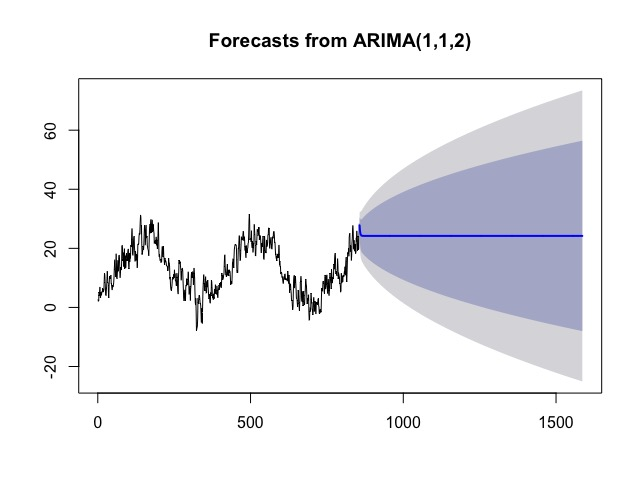
#### Sure, one could argue that with proper pre-processing and carefully tuning the parameters the above graph would not happen.
#### But the truth is that most of us don't either have the patience or the expertise to make it happen.
#### Also, there is the fact that in most practical scenarios- there is often a lot of time-series that needs to be predicted. Eg: This competition. It requires us to predict the next month sales for the Store - item level combinations which could be in the thousands.(ie) predict 1000s of parameters!
#### Another neat functionality is that it follows the typical sklearn syntax.
#### At its core, the Prophet procedure is an additive regression model with four main components:
#### · A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
#### · A yearly seasonal component modeled using Fourier series.
#### · A weekly seasonal component using dummy variables.
#### · A user-provided list of important holidays.
#### Resources for learning more about prophet:
#### · https://www.youtube.com/watch?v=95-HMzxsghY
#### · https://facebook.github.io/prophet/docs/quick_start.html#python-api
#### · https://research.fb.com/prophet-forecasting-at-scale/
#### · https://blog.exploratory.io/is-prophet-better-than-arima-for-forecasting-time-series-fa9ae08a5851


In [39]:
ts

,ds,y
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0
5,2013-06-01,125381.0
6,2013-07-01,116966.0
7,2013-08-01,125291.0
8,2013-09-01,133332.0
9,2013-10-01,127541.0


In [37]:
from fbprophet import Prophet
# prophet requires a pandas df at the blow config
# (date column named as DS and the value column as Y)
ts.columns = ['ds', 'y']
model = Prophet(yearly_seasonality=True) # instantiate Prophet with only yearly seasonality as our data is monthly
model.fit(ts) # fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [38]:
# predict for five months in the future and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957233,80157.850203,86253.821896
35,2015-12-01,125513.062914,122507.614768,128527.676819
36,2016-01-01,75625.688515,72334.504318,78761.262040
37,2016-02-01,40109.144414,36826.923992,43146.889425
38,2016-03-01,76664.084640,73570.379860,79724.131829


In [41]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,141678.041767,129144.079953,135265.464483,141678.041767,141678.041767,-9566.680557,-9566.680557,-9566.680557,-9566.680557,-9566.680557,-9566.680557,0.0,0.0,0.0,132111.361210
1,2013-02-01,139958.210449,127984.590195,133942.368078,139958.210449,139958.210449,-8929.017429,-8929.017429,-8929.017429,-8929.017429,-8929.017429,-8929.017429,0.0,0.0,0.0,131029.193020
2,2013-03-01,138404.814418,144820.353745,151045.310813,138404.814418,138404.814418,9641.575051,9641.575051,9641.575051,9641.575051,9641.575051,9641.575051,0.0,0.0,0.0,148046.389470
3,2013-04-01,136684.983096,104397.706080,110554.693264,136684.983096,136684.983096,-29103.298637,-29103.298637,-29103.298637,-29103.298637,-29103.298637,-29103.298637,0.0,0.0,0.0,107581.684459
4,2013-05-01,135020.630201,104406.815789,110372.341170,135020.630201,135020.630201,-27684.049162,-27684.049162,-27684.049162,-27684.049162,-27684.049162,-27684.049162,0.0,0.0,0.0,107336.581039
5,2013-06-01,133300.755753,119843.375418,126073.449828,133300.755753,133300.755753,-10354.772881,-10354.772881,-10354.772881,-10354.772881,-10354.772881,-10354.772881,0.0,0.0,0.0,122945.982872
6,2013-07-01,131636.019088,110677.450535,116754.576384,131636.019088,131636.019088,-18006.196037,-18006.196037,-18006.196037,-18006.196037,-18006.196037,-18006.196037,0.0,0.0,0.0,113629.823051
7,2013-08-01,129911.539772,121160.453162,127128.358842,129911.539772,129911.539772,-5843.328223,-5843.328223,-5843.328223,-5843.328223,-5843.328223,-5843.328223,0.0,0.0,0.0,124068.211550
8,2013-09-01,128184.848607,125815.919426,132161.126261,128184.848607,128184.848607,739.126229,739.126229,739.126229,739.126229,739.126229,739.126229,0.0,0.0,0.0,128923.974836
9,2013-10-01,126512.306041,124641.368968,131177.105041,126512.306041,126512.306041,1367.070327,1367.070327,1367.070327,1367.070327,1367.070327,1367.070327,0.0,0.0,0.0,127879.376368


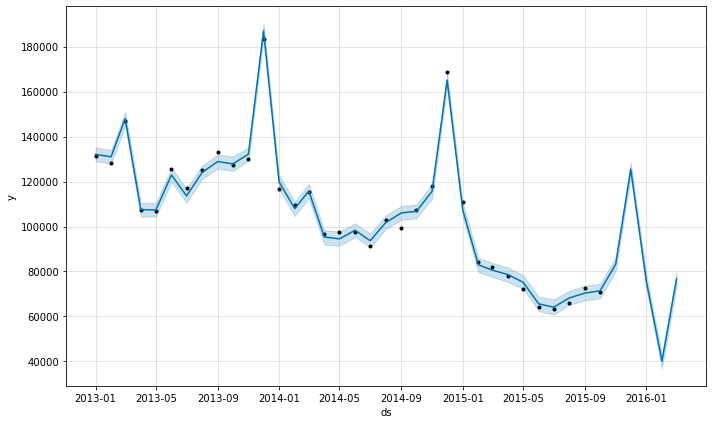

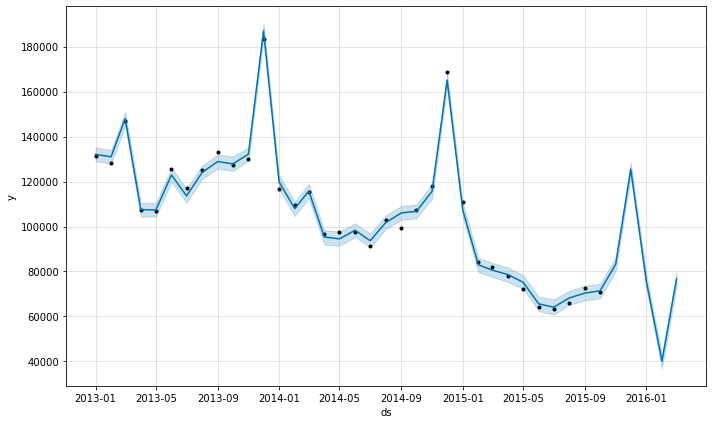

In [40]:
model.plot(forecast)

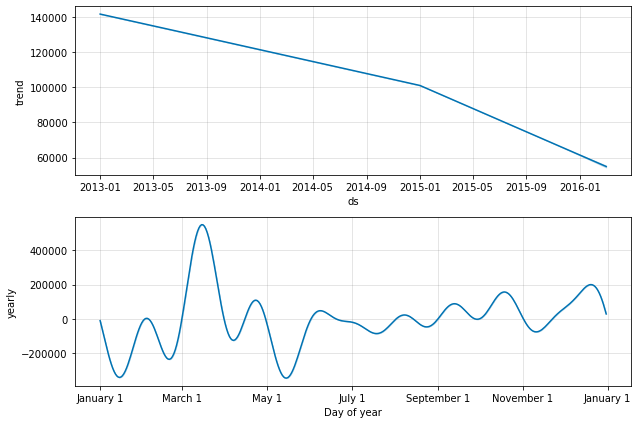

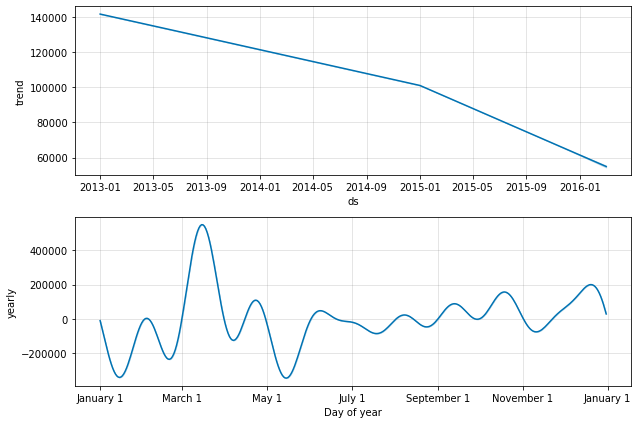

In [42]:
model.plot_components(forecast)

#### Awesome. The trend and seasonality from Prophet look similar to the ones that we had earlier using the traditional methods.

# Hierarchical time series:
#### The Forecasting: principles and practice , is the ultimate reference book for forecasting by Rob J Hyndman.
#### He lays out the fundamentals of dealing with grouped or Hierarchical forecasts. Consider the following simple scenario.
#### Hyndman proposes the following methods to estimate the points in this hierarchy. I've tried to simplify the language to make it more intuitve.

### Bottom up approach:
#### Predict all the base level series using any method, and then just aggregate it to the top.
#### Advantages: Simple , No information is lost due to aggregation.
#### Dis-advantages: Lower levels can be noisy

### Top down approach:
#### Predict the top level first. (Eg: predict total sales first)
#### Then calculate weights that denote the proportion of the total sales that needs to be given to the base level forecast(Eg:) the contribution of the item's sales to the total sales
#### There are different ways of arriving at the "weights".
##### · Average Historical Proportions - Simple average of the item's contribution to sales in the past months
##### · Proportion of historical averages - Weight is the ratio of average value of bottom series by the average value of total series (Eg: Weight(item1)= mean(item1)/mean(total_sales))
##### · Forecasted Proportions - Predict the proportion in the future using changes in the past proportions
#### Use these weights to calcuate the base -forecasts and other levels

### Middle out:
#### Use both bottom up and top down together.
#### Eg: Consider our problem of predicting store-item level forecasts.
##### ·Take the middle level(Stores) and find forecasts for the stores
##### ·Use bottoms up approach to find overall sales
##### ·Dis-integrate store sales using proportions to find the item-level sales using a top-down approach

### Optimal combination approach:
#### Predict for all the layers independently
#### Since, all the layers are independent, they might not be consistent with hierarchy
##### · Eg: Since the items are forecasted independently, the sum of the items sold in the store might not be equal to the forecasted sale of store or as Hyndman puts it “aggregate consistent”
#### Then some matrix calculations and adjustments happen to provide ad-hoc adjustments to the forecast to make them consistent with the hierarchy

### Enough with the theory. Lets start making forecasts! :P
#### The problem at hand here, has 22170 items and 60 stores . This indicates that there can be around a million individual time-series(item-store combinations) that we need to predict!

#### Configuring each of them would be nearly impossible. Let's use Prophet which does it for us.

#### Starting off with the bottoms up approach.

#### There are some other points to consider here:

#### · Not all stores sell all items
#### · What happens when a new product is introduced?
#### · What if a product is removed off the shelves?

In [44]:
total_sales = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
dates = pd.date_range(start='2013-01-01', end='2015-10-01', freq='MS')

total_sales.index=dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [ ]:
# get the uniqe